# CS 5785 2019 Fall Final on Kaggle: Konstantinos Ntalis & Maxwell Wulff

In [132]:
import os
import numpy as np
import pandas as pd
import csv
import random
import gensim
from sklearn import preprocessing
import keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline

### Importing the word2vec dictionary

## First Approach: Classification

In [133]:
num_train = 8000
num_dev = 2000
num_test = 2000
split_idx = list(range(num_train + num_dev))
random.shuffle(split_idx)
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


### Parsing the descriptions and features

In [134]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))


def parse_descriptions(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path) as f:
            docs.append(f.read())
    return docs

def doc_to_vec(sentence, word2vec):
    # get list of word vectors in sentence
    word_vecs = [word2vec.get_vector(w) for w in sentence.split() if w in word2vec.vocab]
    # return average
    return np.stack(word_vecs).mean(0)


def parse_features(features_path):
    vec_map = {}
    with open(features_path) as f:
        for row in csv.reader(f):
            img_id = int(row[0].split("/")[1].split(".")[0])
            vec_map[img_id] = np.array([float(x) for x in row[1:]])
    return np.array([v for k, v in sorted(vec_map.items())])


def remove_stopwords(data):
    output_array = []
    for sentence in data:
        temp_list = []
        for word in sentence.split():
            if word.lower() not in stopwords:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

def remove_punctuation(data):
    output_array = []
    for sentence in data:
        temp_list = []
        for word in sentence.split():
            #if '.' not in word.lower():
            temp_list.append(word.replace('.','').replace(',',''))
        output_array.append(' '.join(temp_list))
    return output_array


# build matrices description 
train_dev_desc = parse_descriptions("data/descriptions_train", num_doc=(num_train+num_dev))
train_dev_desc = remove_stopwords(train_dev_desc)
train_dev_desc = remove_punctuation(train_dev_desc)
test_desc = parse_descriptions("data/descriptions_test", num_doc=num_test)
test_desc = remove_stopwords(test_desc)
test_desc = remove_punctuation(test_desc)
train_desc = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[:num_train]])
dev_desc = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[num_train:]])
test_desc = np.array([doc_to_vec(d, word2vec) for d in test_desc])


# build feature matrices
train_dev_feat = parse_features("data/features_train/features_resnet1000_train.csv")
train_feat = train_dev_feat[split_idx[:num_train]]
dev_feat = train_dev_feat[split_idx[num_train:]]
test_feat = parse_features("data/features_test/features_resnet1000_test.csv") 

### Dictionary of tags

In [4]:
def parse_tags(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path) as f:
            docs.append(f.read())
    return docs

tags = parse_descriptions("data/tags_train", num_doc = (num_train+num_dev))
tags_dict = []

for i in split_idx[:num_train]:
    tags_dict.append(tags[i].replace(' ', '').replace(':', ' ').replace('\n', ' ').split()[1::2])
    
unique_tags = np.unique(np.concatenate(tags_dict))

def tags_b(tags_dict, unique_tags):
    tags = np.zeros((len(tags_dict), len(unique_tags)))
    for i in range(tags.shape[0]):
        for j in range(tags.shape[1]):
            if unique_tags[j] in tags_dict[i]:
                tags[i,j] = 1
                
    return tags
                
tags_bow = tags_b(tags_dict, unique_tags)

### Applying PCA to the ResNet features

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)
pca.fit(train_feat)
train_feat = pca.transform(train_feat)
dev_feat = pca.transform(dev_feat)
test_feat = pca.transform(test_feat)

### Train a model

### b) Neural Network

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Neural network
model = Sequential()

model.add(Dense(600, input_dim = 300, activation = 'relu'))
model.add(Dense(100))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

model.summary()

history_model = model.fit(train_desc, 
                               train_feat, 
                               epochs = 50, 
                               batch_size = 32,
                               validation_split = 0.2)

### Train and validation error rates 

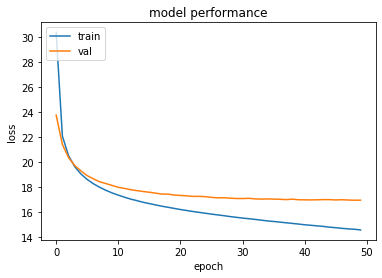

In [7]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

### Create negative samples

In [127]:
adj_matrix = np.zeros((num_train, num_train))

for i in range(num_train):
    if (i % 1000 == 0):
        print(i)
    for j in range(num_train):
        adj_matrix[i,j] = np.sum(tags_bow[i]*tags_bow[j])
        
np.fill_diagonal(adj_matrix, 0)

In [10]:
most_similar = np.flip(np.argsort(adj_matrix, axis = 1), axis = 1)

### Adding negative samples of images. We add images that are very similar to the original but also samples that are very different

In [54]:
feats_predicted = model.predict(train_desc)

to_classify = np.concatenate((feats_predicted, train_feat), axis = 1)
to_classify = np.append(to_classify, np.ones((num_train, 1)), axis = 1)

numsim = 5
nummed = 10
numrand = 10
sim_offset = 500
med_offset = 3000
diff_offset = 6000
tot = numsim + nummed + numrand 

feats_to_add = np.repeat(feats_predicted, repeats = tot, axis = 0)
zrs = np.zeros((feats_to_add.shape[0], 1))
samples = np.zeros((feats_to_add.shape[0], 100))

for i in range(num_train):
    idx1 = np.random.choice(most_similar[i, :sim_offset], numsim, replace = False)
    idx3 = np.random.choice(most_similar[i, sim_offset:med_offset], nummed, replace = False)
    
    idx2 = []
    while len(idx2) < numrand:
        ix = np.random.choice(most_similar[i, diff_offset:])
        if ix not in np.concatenate([[i],idx1,idx2]):
            idx2.append(ix)
    
    idx = np.concatenate([idx1, idx2, idx3])
    samples[i*tot:i*tot+tot] = train_feat[idx]
    
    
to_add = np.concatenate((feats_to_add, samples, zrs), axis = 1)
to_classify = np.vstack((to_classify, to_add))

### Creating a classifier

In [55]:
x_train = to_classify[:,:-1]
y_train = to_classify[:,-1]

from sklearn.utils import shuffle

x_train_shuf, y_train_shuf = shuffle(x_train, y_train)

### Neural Network classifier

In [128]:
# Neural network
model_class = Sequential()


model_class.add(Dense(300, input_dim = 200, activation = 'relu'))

model_class.add(Dense(500, activation = 'relu'))

model_class.add(Dense(300, activation = 'relu'))

model_class.add(Dense(1, activation = 'sigmoid'))

model_class.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model_class.summary()

history_model = model_class.fit(x_train_shuf, 
                               y_train_shuf, 
                               epochs = 25, 
                               batch_size = 32,
                               class_weight = {0: 1., 1: 2})


### Generate ResNet features of test

In [59]:
dev_pred_feats = model.predict(dev_desc)

### Testing the model and computing MAP@20

In [129]:
k = dev_pred_feats.shape[0]
dev_scores = []
dev_pos_list = []

for i in range(k):
    if (i % 100 == 0):
        print(i)
    x_try = np.concatenate((np.repeat(dev_pred_feats[i,:].reshape(-1, 100), k, axis = 0)
                               , dev_feat), axis = 1)
    a = model_class.predict(x_try)
    pred_idx = list(np.argsort(-np.concatenate(a)))
    dev_pos = pred_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)
        
        
print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

### Finally we use our model to compute top-20 predictions on the test data that can be submitted to Kaggle

In [130]:
num_train = 10000
num_test = 2000


# build matrices description 
train_desc = parse_descriptions("data/descriptions_train", num_doc=(num_train))
train_desc = remove_stopwords(train_desc)
train_desc = remove_punctuation(train_desc)
test_desc = parse_descriptions("data/descriptions_test", num_doc=num_test)
test_desc = remove_stopwords(test_desc)
test_desc = remove_punctuation(test_desc)
train_desc = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in range(num_train)])
test_desc = np.array([doc_to_vec(d, word2vec) for d in test_desc])


# build feature matrices
train_feat = parse_features("data/features_train/features_resnet1000_train.csv")
train_feat = train_feat[:num_train]
test_feat = parse_features("data/features_test/features_resnet1000_test.csv") 


tags = parse_descriptions("data/tags_train", num_doc = (num_train))
tags_dict = []

for i in range(num_train):
    tags_dict.append(tags[i].replace(' ', '').replace(':', ' ').replace('\n', ' ').split()[1::2])
    
    
unique_tags = np.unique(np.concatenate(tags_dict))    
                
tags_bow = tags_b(tags_dict, unique_tags)



pca = PCA(n_components = 100)
pca.fit(train_feat)
train_feat = pca.transform(train_feat)
test_feat = pca.transform(test_feat)


history_model = model.fit(train_desc, 
                               train_feat, 
                               epochs = 50, 
                               batch_size = 32,
                               validation_split = 0.2)


# Adjacency matrix
adj_matrix = np.zeros((num_train, num_train))

for i in range(num_train):
    if (i % 1000 == 0):
        print(i)
    for j in range(num_train):
        adj_matrix[i,j] = np.sum(tags_bow[i]*tags_bow[j])
        
np.fill_diagonal(adj_matrix, 0)


most_similar = np.flip(np.argsort(adj_matrix, axis = 1), axis = 1)



# Classification
feats_predicted = model.predict(train_desc)

to_classify = np.concatenate((feats_predicted, train_feat), axis = 1)
to_classify = np.append(to_classify, np.ones((num_train, 1)), axis = 1)

numsim = 5
nummed = 10
numrand = 10
sim_offset = 500
med_offset = 2000
diff_offset = 5000
tot = numsim + nummed + numrand 

feats_to_add = np.repeat(feats_predicted, repeats = tot, axis = 0)
zrs = np.zeros((feats_to_add.shape[0], 1))
samples = np.zeros((feats_to_add.shape[0], 100))

for i in range(num_train):
    idx1 = np.random.choice(most_similar[i, :sim_offset], numsim, replace = False)
    idx3 = np.random.choice(most_similar[i, sim_offset:med_offset], nummed, replace = False)
    
    idx2 = []
    while len(idx2) < numrand:
        ix = np.random.choice(most_similar[i, diff_offset:])
        if ix not in np.concatenate([[i],idx1,idx2]):
            idx2.append(ix)
    
    idx = np.concatenate([idx1, idx2, idx3])
    samples[i*tot:i*tot+tot] = train_feat[idx]
    
    
to_add = np.concatenate((feats_to_add, samples, zrs), axis = 1)
to_classify = np.vstack((to_classify, to_add))


x_train = to_classify[:,:-1]
y_train = to_classify[:,-1]

x_train_shuf, y_train_shuf = shuffle(x_train, y_train)


history_model = model_class.fit(x_train_shuf, 
                               y_train_shuf, 
                               epochs = 25, 
                               batch_size = 32,
                               class_weight = {0: 1., 1: 2})



test_pred_feats = model.predict(test_desc)




# Final prediction
k = test_pred_feats.shape[0]
test_scores = []
test_pos_list = []
pred_rows = []

for i in range(k):
    if (i % 100 == 0):
        print(i)
    x_try = np.concatenate((np.repeat(test_pred_feats[i,:].reshape(-1, 100), k, axis = 0)
                               , test_feat), axis = 1)
    a = model_class.predict(x_try)
    test_dist_idx = list(np.argsort(-np.concatenate(a)))
    top_20 = test_dist_idx[:20]
    row = ["%d.jpg" % i for i in test_dist_idx[:20]]
    pred_rows.append(" ".join(row))

with open("test_submission.csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")

## Second Approach: Regression

### Parsing the descriptions and constructing feature matrices

In [135]:
# build x matrices
train_dev_desc = parse_descriptions("data/descriptions_train", num_doc=(num_train+num_dev))
train_dev_desc = remove_stopwords(train_dev_desc)
train_dev_desc = remove_punctuation(train_dev_desc)
test_desc = parse_descriptions("data/descriptions_test", num_doc=num_test)
test_desc = remove_stopwords(test_desc)
test_desc = remove_punctuation(test_desc)
x_train = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[:num_train]])
x_dev = np.array([doc_to_vec(train_dev_desc[i], word2vec) for i in split_idx[num_train:]])
x_test = np.array([doc_to_vec(d, word2vec) for d in test_desc])

### Parsing the features

In [136]:
# build y matrices
y_train_dev = parse_features("data/features_train/features_resnet1000_train.csv")
y_train = y_train_dev[split_idx[:num_train]]

y_dev = y_train_dev[split_idx[num_train:]]
y_test = parse_features("data/features_test/features_resnet1000_test.csv")


print("Built all y matrices!")
print("y_train shape:", y_train.shape)
print("y_dev shape:", y_dev.shape)
print("y_test shape:", y_test.shape)

Built all y matrices!
y_train shape: (8000, 1000)
y_dev shape: (2000, 1000)
y_test shape: (2000, 1000)


### Applying PCA to the ResNet features

In [137]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 100)
pca.fit(y_train)
y_train = pca.transform(y_train)
y_dev = pca.transform(y_dev)
y_test = pca.transform(y_test)

### Neural network regressor

In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Neural network
model = Sequential()

model.add(Dense(600, input_dim = 300, activation = 'relu'))
model.add(Dense(100))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

model.summary()

history_model = model.fit(x_train, 
                               y_train, 
                               epochs = 50, 
                               batch_size = 32,
                               validation_split = 0.2)

### Train and validation error rates 

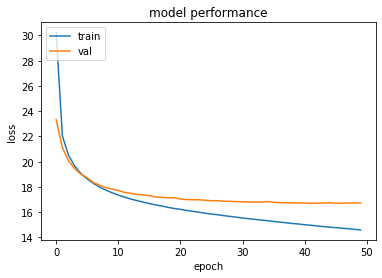

In [139]:
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('model performance')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

### Testing the model and computing MAP@20

In [140]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_similarity
from skimage.measure import compare_ssim


# test performance on development set
y_dev_pred = model.predict(x_dev)
print('Prediction made')
dev_distances = cosine_similarity(y_dev_pred, y_dev)
dev_scores = []
dev_pos_list = []
print('Distances calculated')

for i in range(num_dev):
    pred_dist_idx = list(np.argsort(-dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)

print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

Prediction made
Distances calculated
Development MAP@20: 0.2340653132492722
Mean index of true image 39.6395
Median index of true image 10.0


### Finally we use our model to compute top-20 predictions on the test data that can be submitted to Kaggle

In [ ]:
# create test predictions
x_train_all = np.concatenate([x_train, x_dev])
y_train_all = np.concatenate([y_train, y_dev])
history_model_final = model.fit(x_train, 
                               y_train, 
                               epochs = 100, 
                               batch_size = 64)

y_test_pred = model.predict(x_test)
test_distances = euclidean_distances(y_test_pred, y_test)
pred_rows = []

for i in range(num_test):
    test_dist_idx = list(np.argsort(test_distances[i]))
    top_20 = test_dist_idx[:20]
    row = ["%d.jpg" % i for i in test_dist_idx[:20]]
    pred_rows.append(" ".join(row))

with open("test_submission.csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")